# Анализ работы крупного спортивного магазина

## Загрузка необходимых библиотек

In [1]:
#pip install catboost

In [2]:
#pip install kmodes

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from catboost import Pool, CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.cluster import  KMeans
from sklearn.metrics import silhouette_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, train_test_split, cross_val_score
from sklearn.manifold import TSNE
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc
from scipy.stats import ttest_ind, chisquare, shapiro
from sklearn.pipeline import Pipeline

## Подключение к базе данных

In [4]:
dbfile = 'shop_database.db'
conn = sqlite3.connect(dbfile)

In [5]:
cursor = conn.cursor()

In [6]:
cursor.execute("Select name From sqlite_master Where type='table';")
print(f'Table name :{cursor.fetchall()}')

Table name :[('purchases',), ('personal_data_coeffs',), ('personal_data',)]


In [7]:
# извлечение данных с помощью БД
df_personal = pd.read_sql_query("select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data_coeffs \
                        LEFT join personal_data \
                        on personal_data_coeffs.id=personal_data.id \
                        union \
                        select personal_data_coeffs.id as id, personal_coef, \
                        age, gender, education, city, country from personal_data \
                        LEFT join personal_data_coeffs \
                        on personal_data_coeffs.id=personal_data.id \
                        ", conn)
df_purchases = pd.read_sql_query("SELECT * FROM purchases", conn)
conn.close()

In [8]:
# данных о поле клиента не хватает
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   personal_coef  104989 non-null  float64
 2   age            89241 non-null   float64
 3   gender         89241 non-null   float64
 4   education      89241 non-null   object 
 5   city           89241 non-null   float64
 6   country        89241 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ MB


In [9]:
# открытие сжатого файла c недостающими данными
df_unknown_gender = pd.read_csv("personal_data.csv.gz", compression='gzip')
df_unknown_gender = df_unknown_gender.sort_values("id").reset_index().drop("index", axis=1)
df_unknown_gender["gender"] = None

In [10]:
df_personal_full = df_personal.loc[~df_personal.gender.isna()].reset_index().drop("index", axis=1)
df_personal_not_full = df_personal.loc[df_personal.gender.isna()].reset_index().drop("index", axis=1)

In [11]:
df_personal_not_full = df_personal_not_full.fillna(df_unknown_gender)

In [12]:
df_personal_ = pd.concat([df_personal_full, df_personal_not_full]).reset_index().drop("index", axis=1)

In [13]:
# пропуски
df_personal_.isna().sum()

id                   0
personal_coef        0
age                  0
gender           15748
education            0
city                 0
country              0
dtype: int64

In [14]:
df_personal_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   personal_coef  104989 non-null  float64
 2   age            104989 non-null  float64
 3   gender         89241 non-null   float64
 4   education      104989 non-null  object 
 5   city           104989 non-null  float64
 6   country        104989 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 5.6+ MB


In [15]:
df_personal_.describe()

,id,personal_coef,age,gender,city,country
count,104989.000000,104989.000000,104989.000000,89241.000000,104989.000000,104989.000000
mean,89084.680967,0.458363,38.016707,0.572965,1133.788492,31.989075
std,51414.198487,0.062570,12.283166,0.494650,179.309965,0.943848
min,0.000000,0.233600,5.000000,0.000000,0.000000,0.000000
25%,44532.000000,0.430400,30.000000,0.000000,1134.000000,32.000000
50%,89158.000000,0.468800,38.000000,1.000000,1167.000000,32.000000
75%,133588.000000,0.507200,46.000000,1.000000,1188.000000,32.000000
max,178004.000000,0.558400,77.000000,1.000000,1213.000000,51.000000


C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\1487216084.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap((df_personal_).corr(), cmap='vlag', center=0, square=True, annot = True, linewidths=.5)


<Axes: >

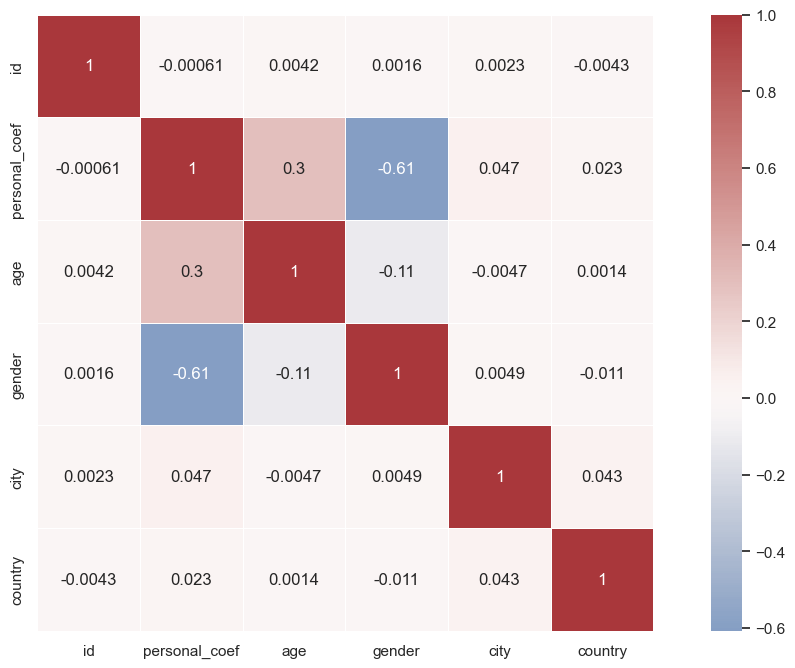

In [16]:
# корреляционная карта
sns.set(rc={'figure.figsize': (15,8)})
sns.heatmap((df_personal_).corr(), cmap='vlag', center=0, square=True, annot = True, linewidths=.5)

In [17]:
# кодировка образования
df_personal_['education_cod'] = df_personal_['education'].apply(lambda x: 1 if x=='высшее' else 0)
df_personal_.drop('education',axis=1, inplace=True)

In [18]:
# разделение выборки на тренировочную и тестовую
df_personal_train = df_personal_[~df_personal_.gender.isna()]
df_personal_test = df_personal_[df_personal_.gender.isna()]

In [19]:
# лес
clf = RandomForestClassifier().fit(df_personal_train.drop("gender", axis=1), df_personal_train.gender)
df_personal_test["gender"] = clf.predict(df_personal_test.drop("gender", axis=1))
df_personal_test.gender.value_counts()

C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\1443657352.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_personal_test["gender"] = clf.predict(df_personal_test.drop("gender", axis=1))


1.0    8940
0.0    6808
Name: gender, dtype: int64

In [20]:
# предсказание
y_pred_proba = clf.predict_proba(df_personal_train.drop("gender", axis=1))[:,1]
metrics = roc_auc_score(df_personal_train["gender"], y_pred_proba)
metrics

1.0

In [21]:
y_pred_proba = cross_val_predict(RandomForestClassifier(),df_personal_train.drop("gender", axis=1),df_personal_train["gender"] ,method='predict_proba')
metrics = roc_auc_score(df_personal_train["gender"], y_pred_proba[:,1])
metrics

0.9999999979472329

In [22]:
# заполнение предсказанными данными
df_fill = df_personal_.fillna(df_personal_test)
df_fill

,id,personal_coef,age,gender,city,country,education_cod
0,0,0.5072,36.0,0.0,1201.0,32.0,0
1,4,0.5072,35.0,0.0,1134.0,32.0,0
2,6,0.4304,52.0,1.0,1188.0,32.0,0
3,7,0.5072,37.0,0.0,1198.0,32.0,0
4,9,0.5072,48.0,0.0,1134.0,32.0,0
...,...,...,...,...,...,...,...
104984,177942,0.4688,23.0,1.0,1134.0,32.0,1
104985,177955,0.4688,24.0,1.0,1193.0,32.0,1
104986,177968,0.4688,49.0,1.0,1157.0,32.0,1
104987,177984,0.5072,43.0,0.0,1204.0,32.0,0


In [23]:
#пропусков нет
df_fill.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104989 entries, 0 to 104988
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             104989 non-null  int64  
 1   personal_coef  104989 non-null  float64
 2   age            104989 non-null  float64
 3   gender         104989 non-null  float64
 4   city           104989 non-null  float64
 5   country        104989 non-null  float64
 6   education_cod  104989 non-null  int64  
dtypes: float64(5), int64(2)
memory usage: 5.6 MB


In [24]:
# файл с покупками
df_purchases

,id,product,colour,cost,product_sex,base_sale,dt
0,0,"Велосипед горный женский Stern Mira 2.0 26""",белый/синий,13599,0.0,1,7
1,0,Стол Outventure,зелёный,1499,NaN,0,37
2,0,Набор Outventure: стол + 4 стула,бежевый,4799,NaN,0,37
3,3,Бутсы мужские GSD Astro,белый,1599,1.0,0,13
4,3,Мяч футбольный PUMA TEAMFINAL 21.2 FIFA QUALIT...,мультицвет,7199,NaN,0,27
...,...,...,...,...,...,...,...
786255,178004,Полуботинки мужские Ascot Vortex,хаки/черный,7999,1.0,0,12
786256,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,13
786257,178004,Кроссовки мужские Nike Air Max 90,черный/серый,24299,1.0,0,20
786258,178004,Пакет,коричневый,12,NaN,0,20


## Готовый сет

In [25]:
df_work = pd.merge(df_fill, df_purchases, on='id')

In [26]:
df_work = df_work[df_work.country==32]
df_work['city'] = df_work['city'].astype('int64')

In [27]:
# без предобработки
for column in df_work.columns:
    print(column)
    print(df_work[column].unique())

id
[     0      4      6 ... 177968 177984 178002]
personal_coef
[0.5072 0.4304 0.5584 0.4688 0.2672 0.2896 0.2768 0.2576]
age
[36. 35. 52. 37. 48. 39. 44. 40. 49. 53. 33. 19. 20. 17. 50. 55. 21. 34.
 38. 29. 62. 41. 31. 43. 16. 32. 18. 30. 23. 25. 42. 24. 63. 45. 56. 58.
 22. 47. 27. 51. 28. 26. 54. 57. 11. 46. 65. 13. 66. 64. 60. 71.  5. 14.
 59. 61. 15. 73.  9.  8. 69. 68. 72. 70.  7. 67. 12. 10. 75.  6. 74. 76.
 77.]
gender
[0. 1.]
city
[1201 1134 1188 1198 1190 1155  574 1178 1157 1203 1137 1204 1187 1181
 1172 1162 1185 1177 1168 1207 1166 1191 1202 1179  913 1154   74 1205
 1167 1159 1141 1142 1180 1150 1160 1199  609 1186 1151 1165 1196 1194
 1175 1161 1195 1173   33 1192 1152  501 1183 1156 1163 1197 1200  218
 1212    9 1176    1   73    0 1182 1153 1189   66 1164   10 1170 1148
 1211 1147 1158  875 1206 1171 1169 1208 1174    2   34 1133 1184   70
  204 1135 1145 1092 1093 1017  104   62  580 1139  917  226 1144 1193
  804  292   61   59  726   76  307  536    7  123  515  2

In [28]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780117 entries, 0 to 786259
Data columns (total 13 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             780117 non-null  int64  
 1   personal_coef  780117 non-null  float64
 2   age            780117 non-null  float64
 3   gender         780117 non-null  float64
 4   city           780117 non-null  int64  
 5   country        780117 non-null  float64
 6   education_cod  780117 non-null  int64  
 7   product        780117 non-null  object 
 8   colour         660936 non-null  object 
 9   cost           780117 non-null  int64  
 10  product_sex    467540 non-null  float64
 11  base_sale      780117 non-null  int64  
 12  dt             780117 non-null  int64  
dtypes: float64(5), int64(6), object(2)
memory usage: 83.3+ MB


In [29]:
df_work.describe()

,id,personal_coef,age,gender,city,country,education_cod,cost,product_sex,base_sale,dt
count,780117.000000,780117.000000,780117.000000,780117.000000,780117.000000,780117.0,780117.000000,780117.000000,467540.000000,780117.000000,780117.000000
mean,89066.851447,0.461144,38.480333,0.553907,1136.165843,32.0,0.200121,5412.478205,0.576190,0.356268,25.122362
std,51411.987985,0.060509,12.176426,0.497086,173.116691,0.0,0.400091,10399.469604,0.494161,0.478896,17.298268
min,0.000000,0.257600,5.000000,0.000000,0.000000,32.0,0.000000,-30.000000,0.000000,0.000000,0.000000
25%,44389.000000,0.430400,31.000000,0.000000,1134.000000,32.0,0.000000,1499.000000,0.000000,0.000000,10.000000
50%,89390.000000,0.468800,38.000000,1.000000,1167.000000,32.0,0.000000,2999.000000,1.000000,0.000000,22.000000
75%,133501.000000,0.507200,46.000000,1.000000,1188.000000,32.0,0.000000,5599.000000,1.000000,1.000000,40.000000
max,178004.000000,0.558400,77.000000,1.000000,1213.000000,32.0,1.000000,446420.000000,1.000000,1.000000,58.000000


## Заполнение колонки colour

In [30]:
df_work['colour'] = df_work['colour'].fillna('Nan')

In [31]:
df_work['colour'].nunique()

1691

In [32]:
# набор букв вместо цвета
garbage_color = set(df_work.colour[[x.isupper() for x in df_work.colour]])


In [33]:
# не засоряй исходный сет
df_work1 = df_work.copy()


In [34]:
df_work1['colour'] = df_work1['colour'].apply(lambda x: 'Nan' if x in garbage_color else x)

In [35]:
color = []
for str_color in df_work1['colour']:
    if "-" in str_color:
        str_color=str_color.split('-')[1]
    if len(str_color.split('/'))>=3:
        color.append('мультицвет')
#        print(str_color)
    else:
         color.append(str_color)
df_work1['colour'] = color
len(set(color))

672

In [36]:
# оставшиеся пропуски
df_work1.isna().sum()

id                    0
personal_coef         0
age                   0
gender                0
city                  0
country               0
education_cod         0
product               0
colour                0
cost                  0
product_sex      312577
base_sale             0
dt                    0
dtype: int64

In [37]:
# названия продуктов в нижний регистр
df_fill_product_sex = df_work1[df_work1['product_sex'].isna()]
df_fill_product_sex['product'] = [x.lower() for x in df_fill_product_sex['product']]

C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\3781075561.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fill_product_sex['product'] = [x.lower() for x in df_fill_product_sex['product']]


In [38]:
# заполнение пропусков на основве названий продуктов
df_fill_product_sex.loc[:,'product_sex'] = [0 if 'жен' in str_product else (1 if 'муж' in str_product else (2 if 'дет' in str_product else 3)) for str_product in df_fill_product_sex['product']]
df_work1 = df_work1.fillna(df_fill_product_sex)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\795063567.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fill_product_sex.loc[:,'product_sex'] = [0 if 'жен' in str_product else (1 if 'муж' in str_product else (2 if 'дет' in str_product else 3)) for str_product in df_fill_product_sex['product']]
C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\795063567.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_fill_product_sex.loc[:,'product_sex'] = [0 if 'жен' in str_product else (1 if 'муж' in str_product else (2 if 

In [39]:
# дубликаты
df_work1[df_work1.duplicated()]

,id,personal_coef,age,gender,city,country,education_cod,product,colour,cost,product_sex,base_sale,dt


In [40]:
# удаление строк со значением цены ниже 0
df_work1 = df_work1.drop(df_work1[df_work1['cost']<=0].index)
df_work1.shape

(780113, 13)

In [41]:
# пропусков нет
df_work1.isna().sum()

id               0
personal_coef    0
age              0
gender           0
city             0
country          0
education_cod    0
product          0
colour           0
cost             0
product_sex      0
base_sale        0
dt               0
dtype: int64

<Axes: >

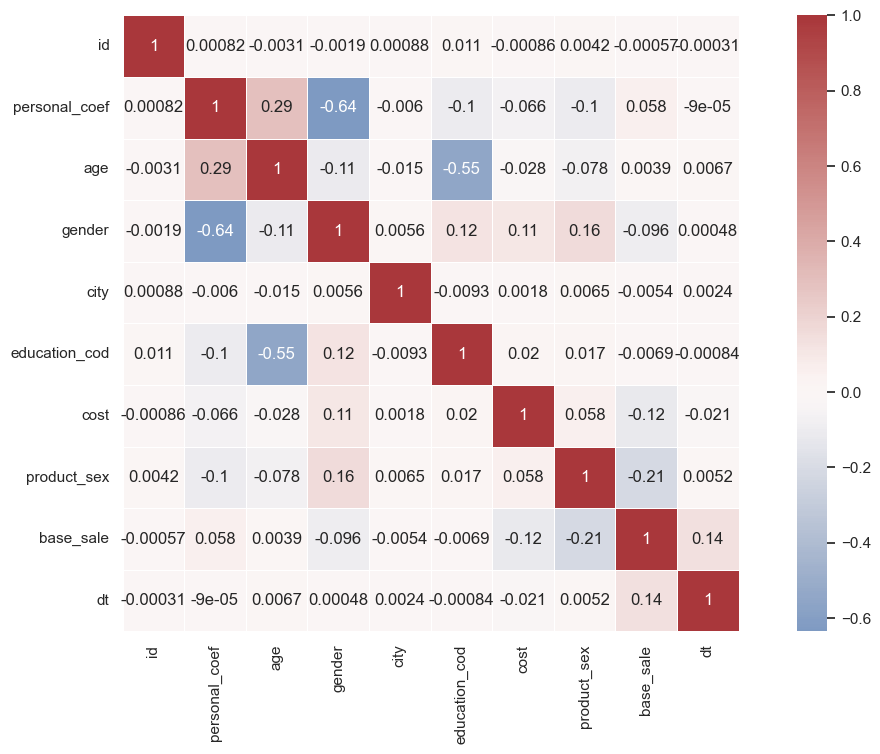

In [42]:
# корреляция
sns.set(rc={'figure.figsize': (15,8)})
sns.heatmap((df_work1.drop(columns=['product','colour','country'],axis=1)).corr(), cmap='vlag', center=0, square=True, annot=True, linewidths=.5)

In [43]:
df_work1.corr()

C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\3503585224.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_work1.corr()


,id,personal_coef,age,gender,city,country,education_cod,cost,product_sex,base_sale,dt
id,1.000000,0.000818,-0.003060,-0.001862,0.000885,NaN,0.011126,-0.000861,0.004234,-0.000566,-0.000308
personal_coef,0.000818,1.000000,0.294878,-0.635527,-0.005973,NaN,-0.100252,-0.066048,-0.101007,0.057691,-0.000090
age,-0.003060,0.294878,1.000000,-0.112307,-0.015303,NaN,-0.548699,-0.027681,-0.078049,0.003886,0.006746
gender,-0.001862,-0.635527,-0.112307,1.000000,0.005617,NaN,0.119686,0.107663,0.158242,-0.096438,0.000476
city,0.000885,-0.005973,-0.015303,0.005617,1.000000,NaN,-0.009269,0.001767,0.006515,-0.005408,0.002442
country,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_cod,0.011126,-0.100252,-0.548699,0.119686,-0.009269,NaN,1.000000,0.020301,0.016612,-0.006861,-0.000840
cost,-0.000861,-0.066048,-0.027681,0.107663,0.001767,NaN,0.020301,1.000000,0.058077,-0.119644,-0.021219
product_sex,0.004234,-0.101007,-0.078049,0.158242,0.006515,NaN,0.016612,0.058077,1.000000,-0.207941,0.005178
base_sale,-0.000566,0.057691,0.003886,-0.096438,-0.005408,NaN,-0.006861,-0.119644,-0.207941,1.000000,0.140127


## AB-test

In [44]:
# пользователи, которым предложили скидку
with open('ids_first_company_positive.txt', 'r') as f:
    contents = f.read()

In [45]:
contents_pos = contents.split('Ids of positive AB people ')[1].replace(',',' ').replace(';',' ').replace('\n','').replace('ahashdgfjshjsd',' ').replace('dtj','').replace('hfghfg','').replace('  ','').replace('yfsdftff',' ').split(' ')
df_pos = pd.Series(data=contents_pos)


In [46]:
df_positive = df_work[df_work['id'].isin(df_pos.astype(int))]


In [47]:
# количество клиентов
df_positive.id.nunique()

4984

In [48]:
# пользователи, которым не предложили скидку
with open('ids_first_company_negative.txt', 'r') as f:
    contents = f.read()

In [49]:
contents_neg = contents.split('Ids of negative AB people ')[1].replace(';;;',' ').replace(';',' ').replace('\n\n','').replace('\n','').replace('kdkdjff','').replace('hsdghdshgd','').replace('hdhdhdhd','').replace(',',' ').replace('  ',' ').replace('|||',' ').split(' ')
df_neg = pd.Series(data=contents_neg)


In [50]:
df_negative = df_work[df_work['id'].isin(df_neg.astype(int))]

In [51]:
df_negative.id.nunique()

4960

In [52]:
# пересечений среди пользователей нет
set(df_positive.id) & set(df_negative.id)

set()

In [53]:
# контрольная и тестовая группы
df_control = df_negative[(df_negative['dt']>=5) & (df_negative['dt']<=16)]
df_test = df_positive[(df_positive['dt']>=5) & (df_positive['dt']<=16)]

<Axes: xlabel='dt', ylabel='Count'>

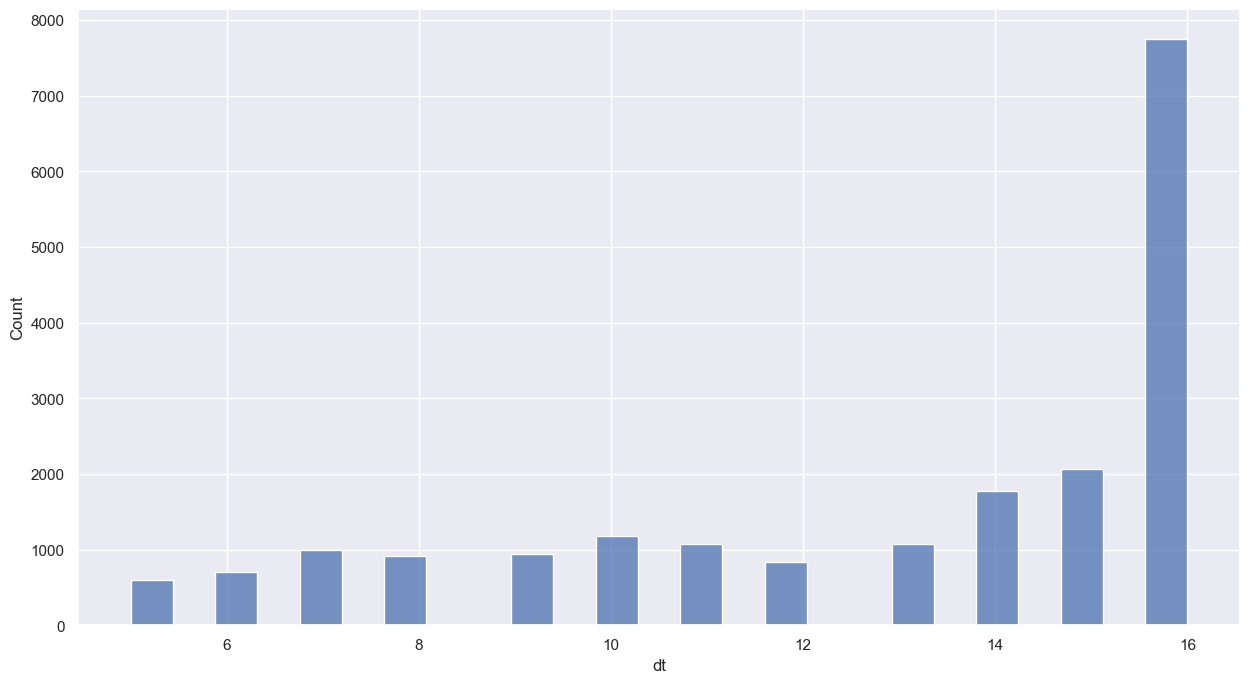

In [54]:
# продажи контрольной группы
sns.histplot(df_control.dt)

<Axes: xlabel='dt', ylabel='product_sex'>

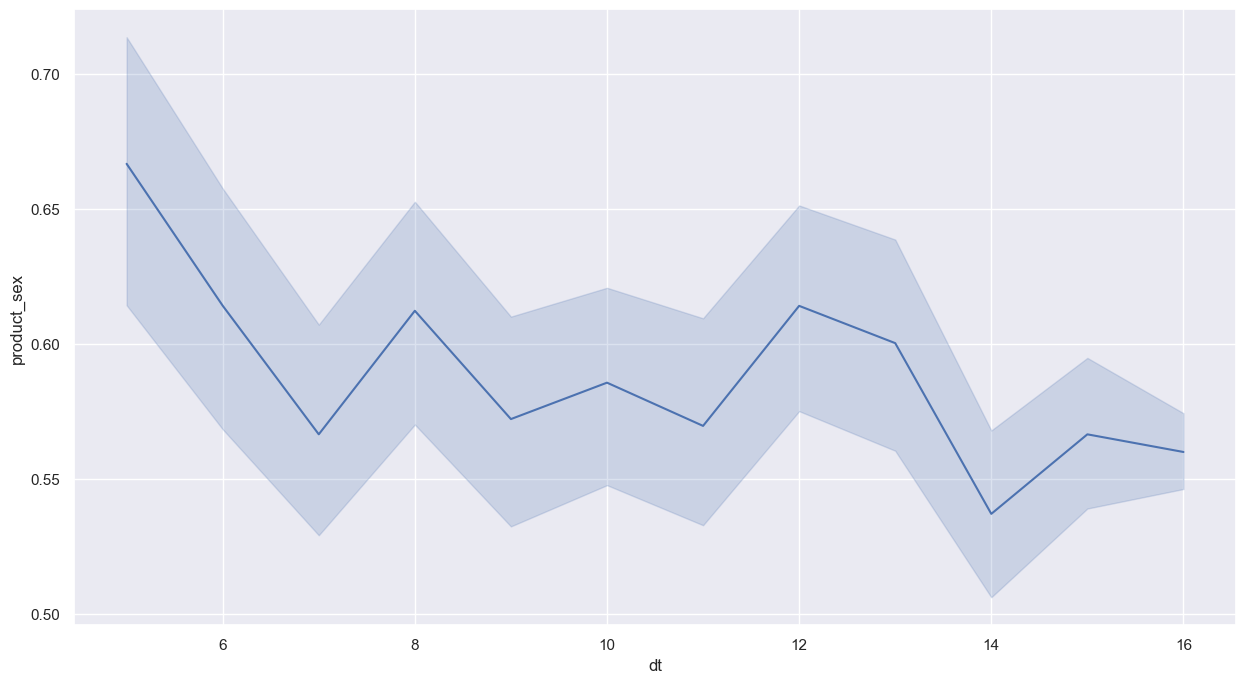

In [55]:
sns.lineplot(x='dt', y='product_sex', data=df_control)

<Axes: xlabel='dt', ylabel='Count'>

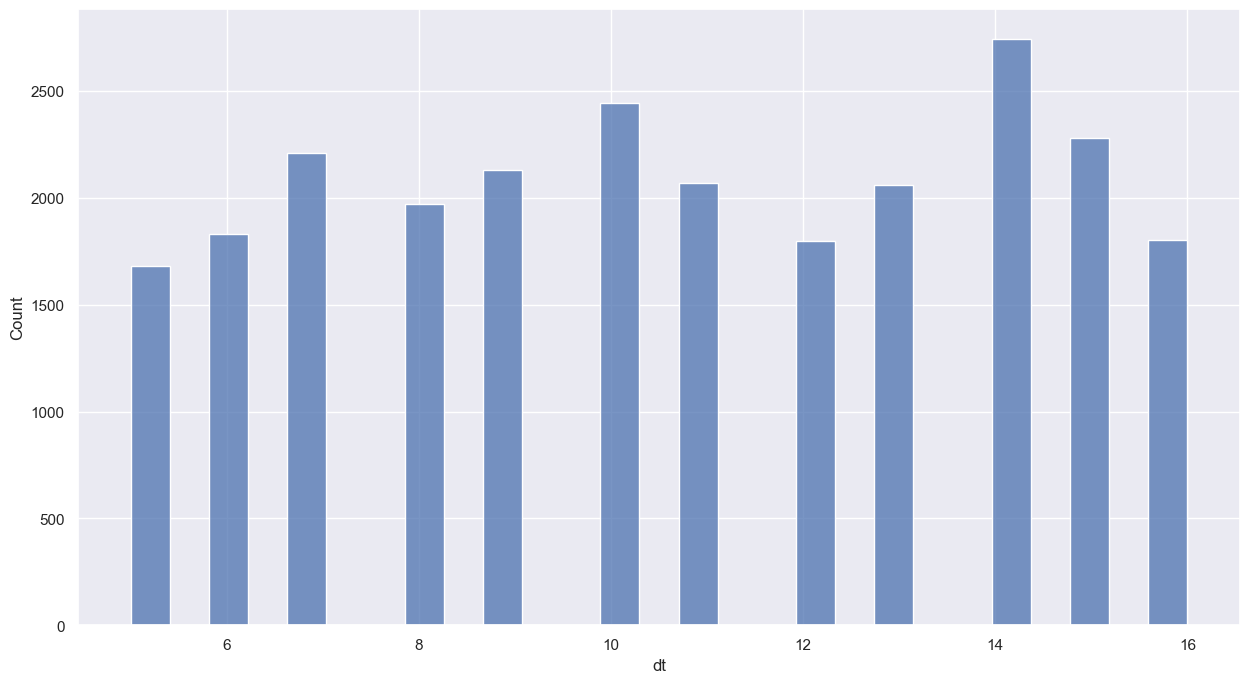

In [56]:
# продажи тестовой группы
sns.histplot(df_test.dt)

<Axes: xlabel='dt', ylabel='product_sex'>

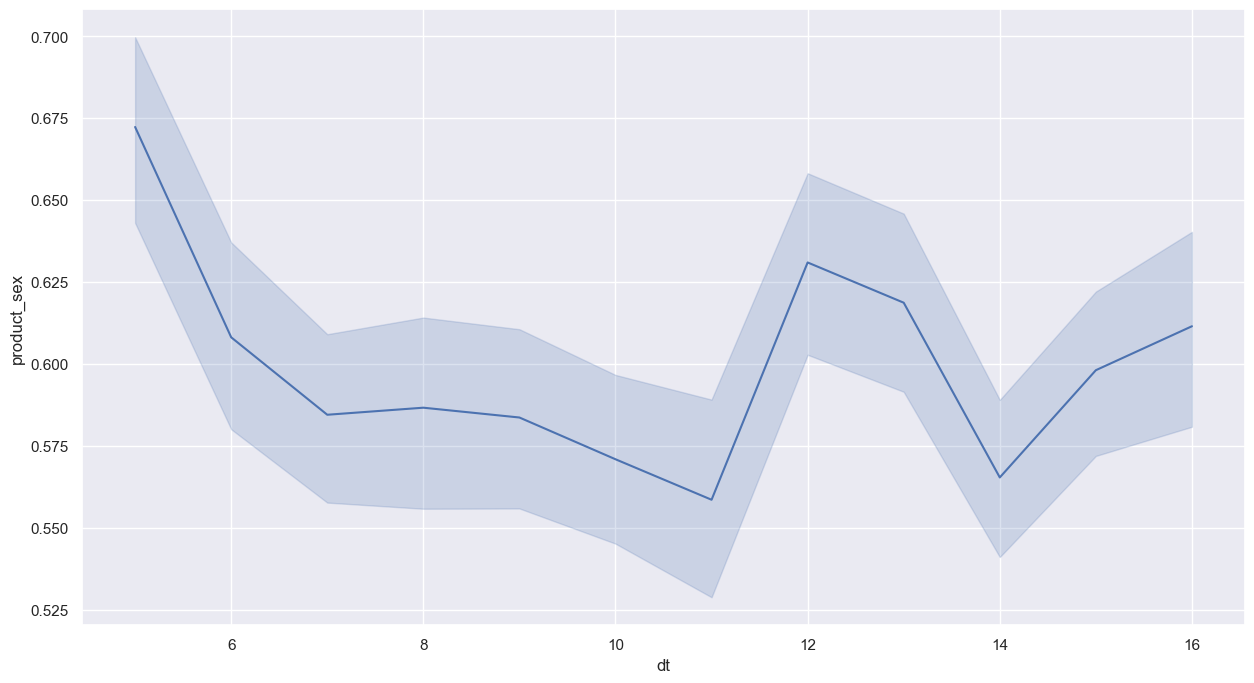

In [57]:
sns.lineplot(x='dt', y='product_sex', data=df_test)

In [58]:
df_control_AB = df_control.groupby('id', as_index=False).agg({'city':'first','age':'mean','gender':'first','cost':'sum','product_sex':'count','dt':'count'})

In [59]:
df_test_AB = df_test.groupby('id', as_index=False).agg({'city':'first','age':'mean','gender':'first','cost':'sum','product_sex':'count','dt':'count'})


In [60]:
# проверка нормальности распределения
from scipy import stats
stats.kstest(df_control_AB.cost, 'norm')

KstestResult(statistic=1.0, pvalue=0.0, statistic_location=59, statistic_sign=-1)

In [61]:
stats.shapiro(df_control_AB)

C:\Users\Acer\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.4739273190498352, pvalue=0.0)

In [62]:
# Проверка дисбаланса групп
total_traffic = df_control_AB.shape[0] + df_test_AB.shape[0]
observed = [df_control_AB.shape[0], df_test_AB.shape[0]]
expected = [total_traffic/2, total_traffic/2]
chi = chisquare(observed, f_exp=expected)
if chi[1] < 0.05:
    print ('SRM may be present')
else:
    print('SRM may not be present')

SRM may not be present


In [63]:
# подсчет средней цены для контрольной и тестовой групп
control_cost = df_control_AB.cost
test_cost = df_test_AB.cost
avg_price_c = df_control_AB.cost.mean()
avg_price_t = df_test_AB.cost.mean()
print(f'Среднее значение стоимости корзины для  контрольной группы : {avg_price_c} для тестовой группы: {avg_price_t}')
#t_test = ttest_ind(control_cost, test_cost, equal_var=False)
t_test = stats.mannwhitneyu(control_cost,test_cost, alternative='less')
if t_test[1] < 0.05:
    print(f' Разница статистически значима')
else:
    print(f'Разница не существенна')
t_test

Среднее значение стоимости корзины для  контрольной группы : 22450.308064516128 для тестовой группы: 27794.01068062827
 Разница статистически значима


MannwhitneyuResult(statistic=10013087.0, pvalue=4.76991226931274e-40)

In [64]:
df_control_AB['group'] = 'control'
df_test_AB['group'] = 'test'
df_union_AB = df_control_AB.append(df_test_AB)

C:\Users\Acer\AppData\Local\Temp\ipykernel_12760\471680117.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_union_AB = df_control_AB.append(df_test_AB)


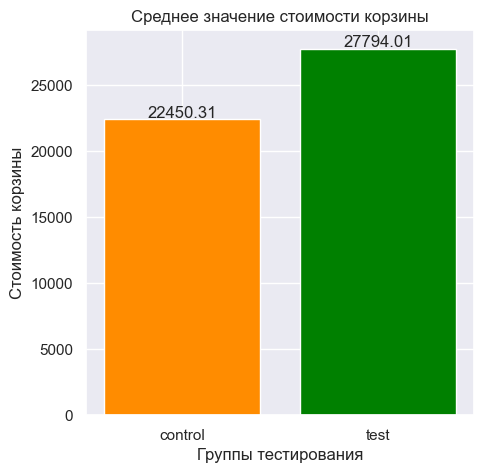

In [65]:
df_graphic = df_union_AB.groupby('group', as_index=False)['cost'].mean()
plt.figure(figsize=(5,5))
plt.bar(df_graphic['group'], df_graphic['cost'], color=['darkorange','green'])
plt.xlabel('Группы тестирования')
plt.ylabel('Стоимость корзины')
plt.title('Среднее значение стоимости корзины')
for i, val in enumerate(df_graphic['cost']):
    plt.text(i, val+100, str(round(val,2)), ha='center');

In [66]:
# подсчет среднего количества товаров для контрольной и тестовой групп
control_product = df_control_AB.product_sex
test_product = df_test_AB.product_sex
avg_product_c = df_control_AB.product_sex.mean()
avg_product_t = df_test_AB.product_sex.mean()
print(f'Среднее значение количества товаров в корзине для  контрольной группы : {avg_product_c} для тестовой группы: {avg_product_t}')
t_test = stats.mannwhitneyu(control_cost,test_cost)
if t_test[1] < 0.05:
    print(f' Разница статистически значима')
else:
    print(f'Разница не существенна')
t_test

Среднее значение количества товаров в корзине для  контрольной группы : 2.40625 для тестовой группы: 3.1250261780104713
 Разница статистически значима


MannwhitneyuResult(statistic=10013087.0, pvalue=9.53982453862548e-40)

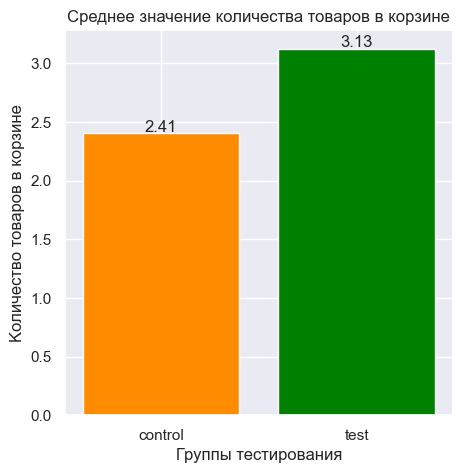

In [67]:
df_graphic = df_union_AB.groupby('group', as_index=False)['product_sex'].mean()
plt.figure(figsize=(5,5))
plt.bar(df_graphic['group'], df_graphic['product_sex'], color=['darkorange','green'])
plt.xlabel('Группы тестирования')
plt.ylabel('Kоличествo товаров в корзине')
plt.title('Среднее значение количества товаров в корзине')
for i, val in enumerate(df_graphic['product_sex']):
    plt.text(i, val+0.01, str(round(val,2)), ha='center');

### Вывод:Обе метрики показали статистически значимую разницу, что позволяет считать проведенную маркетинговыу кампанию успешной

## АНОМАЛИИ

In [68]:
clf = LocalOutlierFactor()
pred = clf.fit_predict(df_work1.drop(columns=['id','product','colour'], axis=1))
df_work1.loc[:,'anomaly'] = np.where(pred == -1, 1, 0)

In [69]:
df_work1.anomaly.value_counts()

0    762841
1     17272
Name: anomaly, dtype: int64

### Разделение продуктов на категории

In [70]:
df_work1['product'] = [x.lower() for x in df_work1['product']]

In [71]:
dresses = ['куртка','футболка','бейсболка','носки','джемпер','бейсболк','бейсболки','моделирующие','гольфы,','перчатка','пояс','легкая','пончо','велошорты','спортивный','свитер','полупальто','флисовый','полукомбинезон','поло','леггинсы','балаклава','носки','рубашка-поло','юбка-шорты','шорты-сауна','шорты-самосбросы','шапка-шлем','халат-пончо','футболки','накидка-дождевик','носки,','компрессионный','компрессионные','куртка-анорак','кепка','гольфы','брюки','джерси','гетры','бордшорты','брюки-самосбросы','брюки-шорты','платье','майка','худи','ветровка','костюм-сауна','олимпийка','рашгард','шорты','лиф','лонгслив','шапка','панама','бомбер','свитшот','бриджи','рубашка','гейтор','жилет','легинсы','юбка','туника','толстовка','костюм','пуховик','перчатки','бандана','повязки','анорак','термобелье','велосипедки','перчатки','топ','пальто','гольфы','трусы','бра','teryx','накидка','Тайсы','Шарф','Тайтсы','Манишка','Поло','Кальсоны','Водолазка','Боди','Рейтузы','Бомбер','Парка','Ремень','Варежки','Накидка','Ремни','Снуд','Ремешок','Бейсболка','Термобелья','Термобелье','Лосины','Комбинезон']
bags = ['рюкзак','рюкзак-упаковка','рюкзак-жилет', 'сумка','несессер','подседельная','термосумка','Мешок','Подсумок','мешок','баул','гермомешок','герморюкзак','рюкзаки','сумка-баул','сумки','сумка-шоппер','сумка-пояс','сумка-шопер','сумка-чехол','чемодан','чехол-тубус']
boots = ['кроссовки','кеды', 'ботинки','бутсы', 'сандалии','велоботинки','полусапоги', 'балетки','получешки','гамаши','обувь','полуботинки', 'слипоны','шлепанцы', 'сапоги','эспадрильи','борцовки','сабо','Чешки','Шиповки','Сороконожки','Велообувь','Туфли','Мокасины','Джазовки','Снегоступ','Тапочки','Велотуфли','Боксерки']
activity = ['Велосипед','спальный','гироскопический','массажный','шингарты','гребной','душ-гермомешок','наклонная','силовая','силовой','треккинговые','ролики','кольцо','снегокат','пакрафт','мини-круизер','перчатки-бинты','наборная','утяжелители,','ролик','палатка-тент','комплект:','тейп','массажно-балансировочная','эспандерный','лента-эспандер','велотренажер','напульсники','фитнес-коньки','плавки-шорты','перчатки-утяжелители','инверсионный','беговые','скейтборд','мини-тренажер','самокат','санки-ледянки','эспандеры','беговая','электровелосипед','ленты','накатка','лыжероллеры','блок','виброгаситель','виброгасители','балансировочный','балансировочная','эспандер-лента','теннисный','эллиптический','тент','утяжелитель','утяжелители','турник-брусья','стропа','стропы','мини-степпер','стрелы','стол','мячи','мини-ракетка','мини-круизер','круизер','бейсбольная','манжеты','мини-велотренажер','лыжи','жилет-утяжелитель','доска-калабашка','роликовые','шлем','гантели','коньки','клюшка','булавы','электросамокат','Дорожка','Лестница','самокат','Мяч','Ворота','Палатка','Лодка','стол','Коврик','Спиннинг','Палки','Тент','Кресло','SUP','платформа','воланы','степпер','Игра','Гермосумка','Гидрокостюм','Ракетка','Шапочка','Гантель','Круизер','Фитнес-браслет','Кровать-раскладушка','Скамья','Тренажер','Щитки','Добок','Роллерсерф','Маркер','Трапеция','Фитнес','Брусья','Воблер','Тюбинг','Бассеин','Напульсник','Налокотники','Свимбейт','Шайба','Нагрудник','Макивара','Щит','Сноуборд','Гиря','Роллер','Гермобаул','Гантел','Лопата','Кастрюля','Котел','Кухня','Лампа','Крышка','Станок','Сетка','Сматыватель','Стул','Чайник','Доска','Бандаж','Кардиопояс','Кофеварка','Скейтборд','Батут','Одеяло','Катамаран','Беговел','Пуллер','Топор','Колобашка','Обруч','Утяжелител','Флиппер','Эспандер','Турник','Связки','Лапк','Флексор','Крепления','кораблик','Фитбол','Гермомешок','Круг','Джерси','Лент','Темляк','Гриф','Плед','Лент','Виброхвост','Лодка','Кимоно','Нунчаки','Матраc','Таз','Бодибар','Гамаши','Матрац','Kлюшка','Скакалка','Степпер','Байдарка','Лонгборд','Санки','Шагомер','Груша','Лук','Крючок','Пульсометр','Медицинбол','Веломаска','Ласты','Подушка','Гетры','Кофемолка','Мангал','Нарукавники','Мишень','Блесна','Трико','Бинокль','Массажер','Мат','Эхолот','Наколенники','Сноускейт','Полотенце','Бикини','купальник','плавки','Весло','Гамак','Эргометр','Коптильня','Комплекс','Картплоттер','Степ-платформа','Седло','Компас','Скейтборд','Щепочница','Велобриджи','Турник','Кардиодатчик']
acessories = ['Фишки', 'ремонтный','комплект', 'насос','протеиновые','ручки','адаптеры','батарейки','батончики','бактерицидный','альфа-липоевая','секундомер','набор:','щетка-скребок','цепная','карман','беспроводные','водоотталкивающая','боковые','веганский','антибактериальные','активная','протеиновый','защитный','стул-рюкзак','настольная','ложка','комбинированная','москитная','салфетки','очищающие','протеиновое','подседельный','настольный','щипцы','котелок','подарочная','стул-табурет','моющее','складной','смазка','энергетик','кинезио-тейп','кинезиотейп','газовый','фруктовые','сушилки','упоры','пеги','фруктовый','переднее','фьюз','тормозная','тормозной','пуллеры','ремень-держатель','таганок','тарелка','чистящая','газовая','маркер-краска','добавка','ключ','колеса','клапан','передний','заднее','задний','часы','шампуры','низкокалорийное','фонарь','система','влажные','витаминная','защита','тормозные','витамин','очиститель','витаминно-минеральный','омега-3','наклейка','насос-помпа','переходник-адаптер','фляжка','наконечники','тату-наклейки','грипсы','станок-профиль','фибертекс','грипса','термос-подсумок','мультифонарь','термобутылка','мультиключ','лезвия','вентилятор','л-карнитин','велосипедный','велосипедная','таймер','крепление','солнцезащитные','спираль','спички','обмотка','сменный','наклейки','баланс','бассейн','накладка','накладки','заплатки','лапа','зеркало','держатель','зарядное','датчик','диски','аэрозоль','выжимка','губка-очиститель','грунт','глюкозамин','аэрозоль-репеллент','аквагрим','Насос','аминокислоты','веревки-растяжки','брызговик','бутылки','велокрепление','велостанок','велокресло','Фонарь','буксир','буксировочный','воск','ветряк','бинты','воблер','Леска','Матрас','очки','Нож','Игла','Мультиключ','Флягодержатель','Звонок','Подножка','Бутылка','Дезодорант','Украшение','Термос','Набор','Маска','Полотенце','Протеин','Крепления','Стойки','Втулка','колесо','Миска','Тормоз','шатунов','Крыло','Цепь','Гель','Кошелек','Сидушка','карта','Подвеска','Горелка','лента','Беруши','Грипс','Водоотталкивающий','Парус','Имитатор','Твистер','Пробка','Краска','Энергетический','Монитор','Заглушки','Скребок','Магний','Струна','Машинка','Покрытие','Колодки','Руль','Волан','Флаг','винт','Цилиндр','Магнезия','Препарат','Банка','Гермочехол','Велопедали','Аминокислота','Щуп','Омега','Дартс','Диск','Трубка','Растяжитель','Эмульсия','Резинки','Бушинги','Манометр','Шланг','Жиросжигатель','Покрышка','Тату','Трос','Костровый','Коробка','баллон','Cмазка','Рукоятка','Эксцентрик','Наушники','Камера','Брелок','Термокружка','Багажник','Брызговики','Клистер','Сквиш','Ластик','Гудок','Тормоз','Кошелек','Козырек','Оперения','Педали','Фильтр','Протеин','Петли','Переходник','Ловилка','Бутылка','Панкейк','Фляга','Суппорты','Резервуар','Рукава','Комборучки','Мазь','Подпяточники','Стик','Вставки','Казеин','Замок','Дротики','Электролиты','Маркер','Утюг','Адаптер','Вкладыши','Печенье','Повязка','Гейнер','Держатели','Растяжки','Резинка','Конус','Наклейк','Волан','Карнитин','Бинт','Футляр','Древко','Бумеранг','Стакан','Гидролиния','Велоэргометр','Лосьон','Хвостовики','Удилище','Зажим','Покрышка','Наконечник','Туба','Накладк','Палк','Шарнир','Пена','Диск','Органайзер','Коллаген','Пила','Ремкомплект','Насос','Половник','Тейл','Звонок','Батончик','Бакля','Намотка','Наколенник','Светильник','Витамины','Гребенка','Мелатонин','Игра','Карабин','Стойки','Косметичка','Изотоник','Рога','Поле','Манжет','Кошк','Пиколинат','Весы','Каретка','Плита','Упаковка','Салфетка','Оголовник','Батарейк','Чапельник','Колпач','Стрел','Свисток','Тиски','Визор','Капа','Средство','Рулетка','Камус','Линза','Игла','Смывка','Крем','Пропитка','Пряжка','Мультиключ','Колышек','Мультитул','Липучк','Велокомпьютер','Качели','Переключатель','Огниво','Канторез','Напиток','Кружка','Лезви','Зеркал','Барабан','Компресс','Катушка','Пятновыводитель','Леска','Расширител','Подтяжки','Вкладыш','Веревка','Ящик','Заплатк','Монтажки','Звезда','Креатин','Затачиватель','Фляжка','Червь','Помада','Щетка','Запчасть','Суппорт','Фрисби','Репшнур','Кольц','Браслет','Аквагримм','Затягиватель','Колодка','Омега','Вынос','Пакет','Корзина','Сиденье','Экран','Лиш','Мюсли','Незацепляйка','Дуги','Канат','Губка','Спрей','Болты','Стяжка','Жердь','Контейнер','Нейтрализатор','Связка','Шифтер','Трещотка','Сушилк','Чехлы','Переходник','Кружки','Бакл','Дождевик','Подножка','Антифог','Барьер','Грелка','Щетка','Манжета','Аккумулятор','Шейкер','Глютамин','Стельки','Тарзанка','Стрессбол','Аптечка','Надставка','Решетка','Чехол','Cуппорт','Сушка','Подшипник','Шкурка','Крюк','Шнурки','Вилка','Подошв','Шампур','Фартук','Чашка','Шнурок','Плоскогубцы','Замки','репеллент','Подставка','Душ','Термоконтейнер','оперения','Ось','Тренога','Безмен','Блин']

In [72]:
dresses=[x.lower()for x in dresses]
bags=[x.lower()for x in bags]
boots=[x.lower()for x in boots]
activity=[x.lower()for x in activity]
acessories=[x.lower()for x in acessories]

In [73]:
cat = {'dress':dresses, 'bag':bags, 'boots':boots,'activity':activity, 'acessories':acessories}

In [74]:
prods = []
for product in df_work1['product']:
    ex = product.split(' ')
    i=0
    for cloth, values in cat.items():
        if (ex[0] or ex[1]) in values:
            prods.append(cloth)
            i=0
            break
        else:
            i+=1
        if i==len(cat):
            prods.append('other')
df_work1.loc[:,'products']=prods

In [75]:
df_work1['products'].value_counts()

dress         325641
boots         250049
activity       99742
acessories     68606
bag            28691
other           7384
Name: products, dtype: int64

In [76]:
df_w =df_work1[df_work1.anomaly==0]

## кластеризация

In [77]:
df_clust = df_w.drop(columns=['id', 'country','product'],axis=1)

In [78]:
label = LabelEncoder()

In [79]:
df_clust['colour'] = label.fit_transform(df_clust['colour'])
df_clust['products'] = label.fit_transform(df_clust['products'])

In [80]:
tsne = TSNE(n_components=2)
df_tsne = tsne.fit_transform(df_clust)

In [81]:
#kprop = []
#N = 8
#for k in range(2, N):
#    kp = KPrototypes(n_clusters=k, init='random', n_init=5, verbose=1)
#    kp.fit(df_clust, categorical= [6,12])
#    kprop.append(kp.cost_)

In [82]:
#plt.plot(range(2, N), kprop, marker='s');
#plt.xlabel('$k$')
#plt.grid()
#plt.ylabel('$J(C_k)$');

In [83]:

kp = KPrototypes(n_clusters=4, init='random', n_init=5, verbose=1)
#kp.fit(df_clust, categorical= [6,12])

In [84]:
#df_clust_1 = df_clust.copy()
clusters = kp.fit_predict(df_clust,categorical= [5,11])
df_clust.insert(0,'cluster', clusters, True)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 117267, ncost: 23164878092845.29
Run: 1, iteration: 2/100, moves: 56724, ncost: 19034985368115.066
Run: 1, iteration: 3/100, moves: 14159, ncost: 18111484053661.164
Run: 1, iteration: 4/100, moves: 10346, ncost: 17821120802720.543
Run: 1, iteration: 5/100, moves: 9507, ncost: 17730413206160.38
Run: 1, iteration: 6/100, moves: 13198, ncost: 17677564845775.875
Run: 1, iteration: 7/100, moves: 8158, ncost: 17586973216772.467
Run: 1, iteration: 8/100, moves: 9622, ncost: 17501782509362.217
Run: 1, iteration: 9/100, moves: 19344, ncost: 17361491410836.025
Run: 1, iteration: 10/100, moves: 16665, ncost: 17148165351927.324
Run: 1, iteration: 11/100, moves: 12686, ncost: 16987639381611.207
Run: 1, iteration: 12/100, moves: 11757, ncost: 16716868370117.006
Run: 1, iteration: 13/100, moves: 12621, ncost: 16159564702257.547
Run: 1, iteration: 14/100, moves: 18399, ncost: 15442918124574

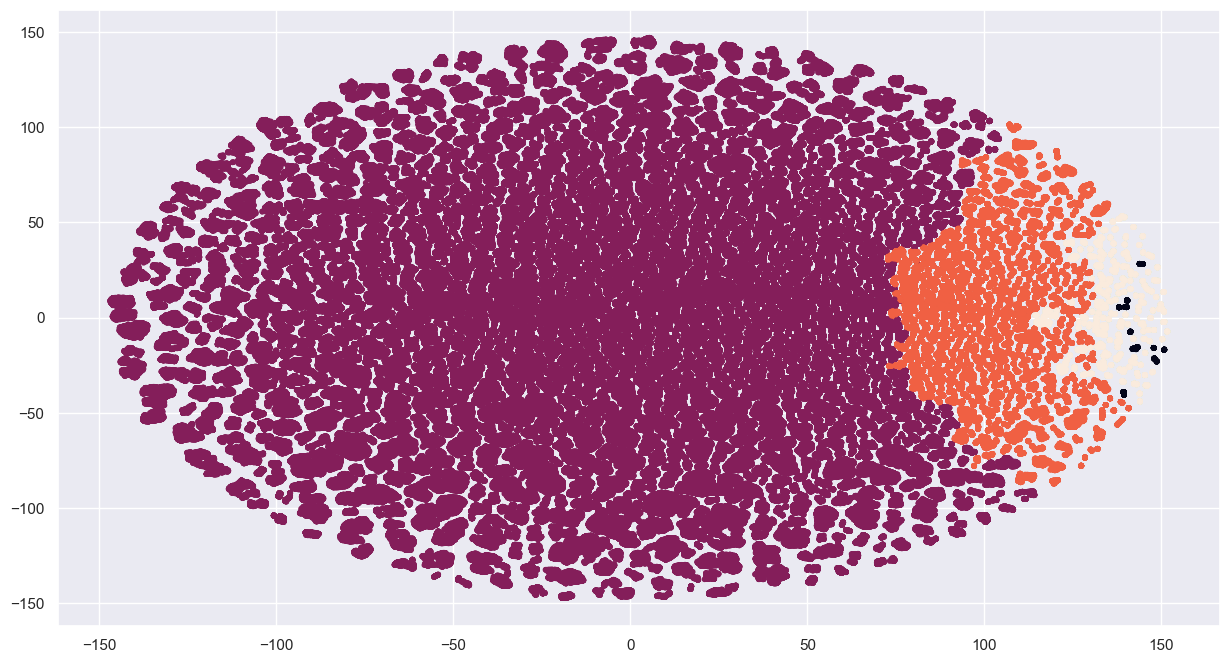

In [85]:
plt.scatter(df_tsne[:,0], df_tsne[:,1], s=10, c=kp.labels_);

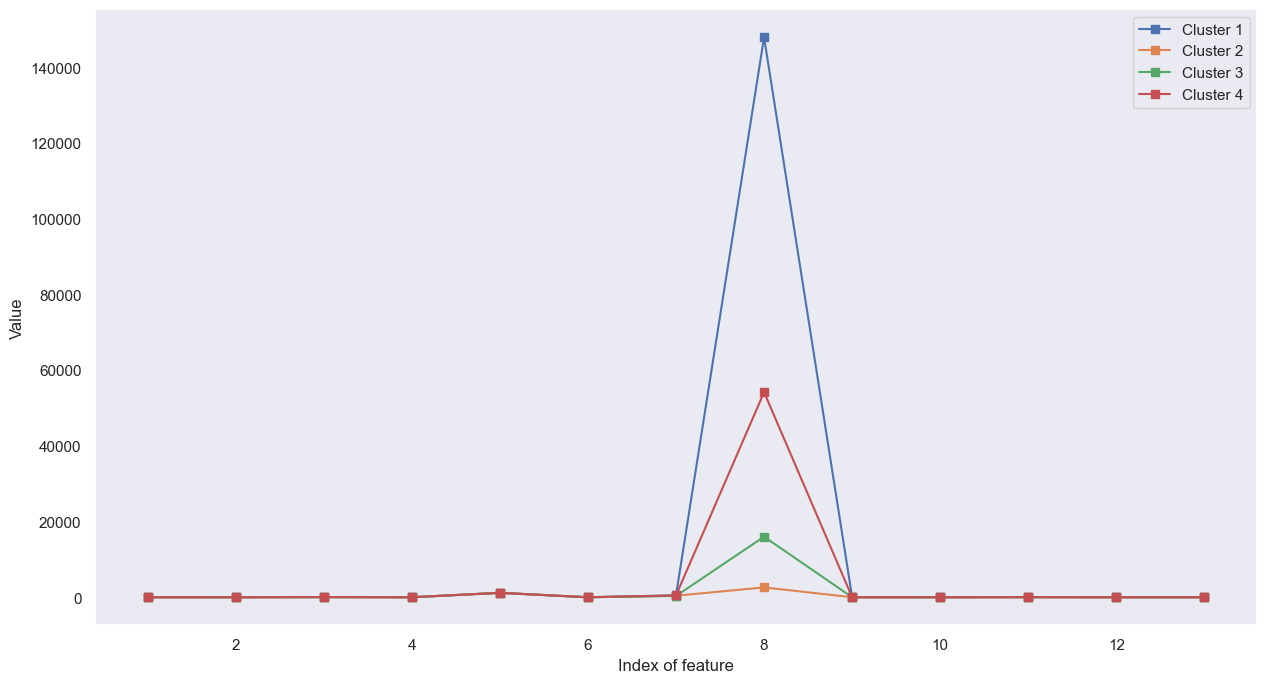

In [86]:
plt.plot(range(1, df_clust.shape[1]+1), np.median(df_clust[kp.labels_ == 0], axis=0), marker='s', label="Cluster 1");
plt.plot(range(1, df_clust.shape[1]+1), np.median(df_clust[kp.labels_ == 1], axis=0), marker='s', label="Cluster 2");
plt.plot(range(1, df_clust.shape[1]+1), np.median(df_clust[kp.labels_ == 2], axis=0), marker='s', label="Cluster 3");
plt.plot(range(1, df_clust.shape[1]+1), np.median(df_clust[kp.labels_ == 3], axis=0), marker='s', label="Cluster 4");
plt.legend()
plt.xlabel('Index of feature')
plt.grid()
plt.ylabel('Value');

# для 4 кластеров

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


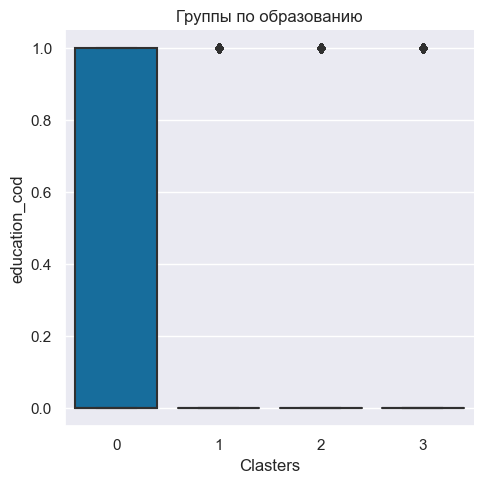

In [87]:
sns.catplot(kind='box', data=df_clust,
            y='education_cod',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по образованию')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


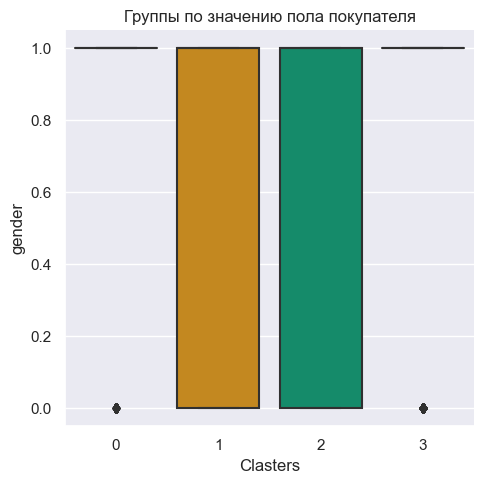

In [88]:
sns.catplot(kind='box', data=df_clust,
            y='gender',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по значению пола покупателя')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


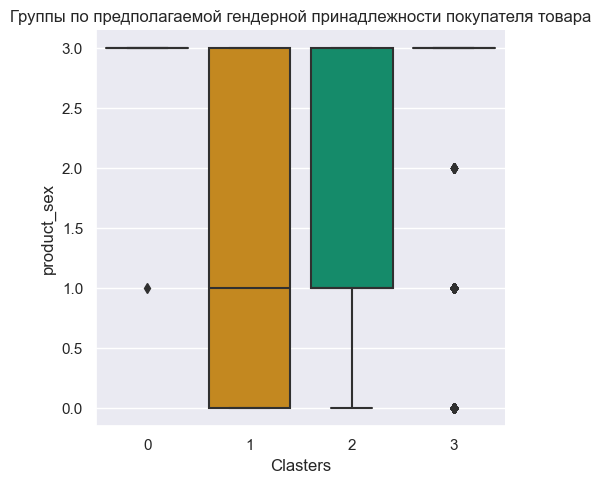

In [89]:
sns.catplot(kind='box', data=df_clust,
            y='product_sex',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по предполагаемой гендерной принадлежности покупателя товара')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


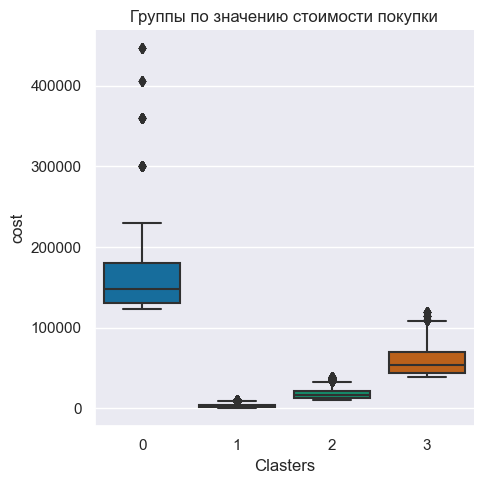

In [90]:
sns.catplot(kind='box', data=df_clust,
            y='cost',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по значению стоимости покупки')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


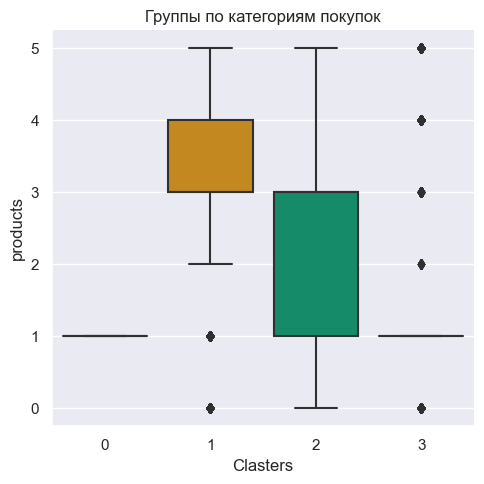

In [91]:
sns.catplot(kind='box', data=df_clust,
            y='products',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по категориям покупок')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


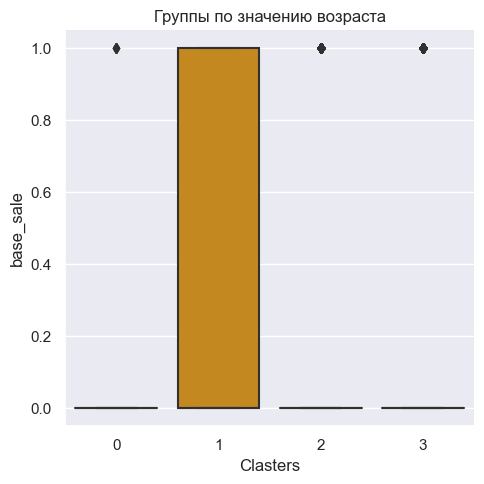

In [92]:
sns.catplot(kind='box', data=df_clust,
            y='base_sale',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по значению возраста')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

C:\Users\Acer\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


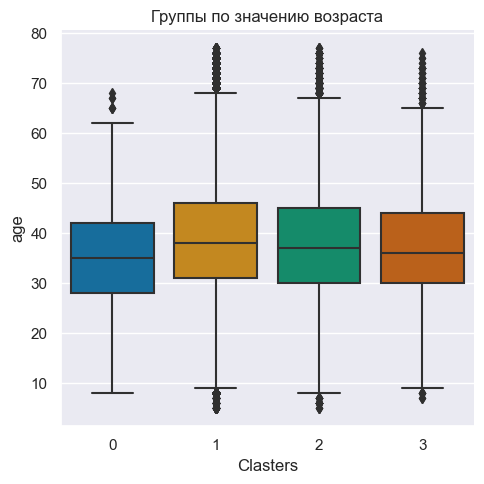

In [93]:
sns.catplot(kind='box', data=df_clust,
            y='age',
            x=kp.labels_,
            palette="colorblind", sharey=False)
plt.title('Группы по значению возраста')
plt.xlabel('Clasters')
plt.tight_layout()
plt.show()

<Axes: xlabel='cluster', ylabel='Count'>

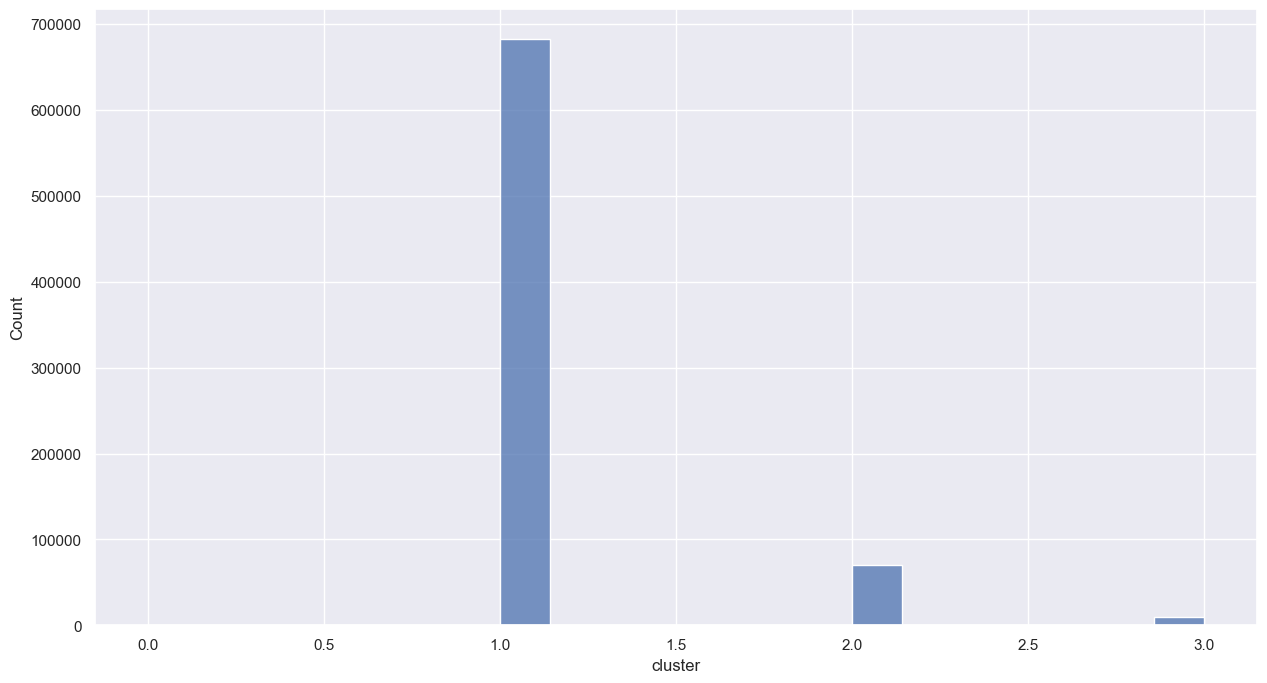

In [94]:
sns.histplot(df_clust.cluster)

In [95]:
df_w.insert(0,'cluster', clusters, True)

In [102]:
df_w.cost.quantile(0.25)

1499.0

In [104]:
df_w.cost.quantile(0.95)

17599.0

In [100]:
#df_w[df_w.cluster==1]['cost'].min()

12

# Предсказание склонности к покупке

In [99]:
df_work1.insert(0,'cluster', clusters, True)

In [100]:
df_work1_count = df_work1.groupby('cluster', as_index=False).agg(clust_count = ('id','count'))
df_work1_count.sort_values(by='clust_count', inplace=True)

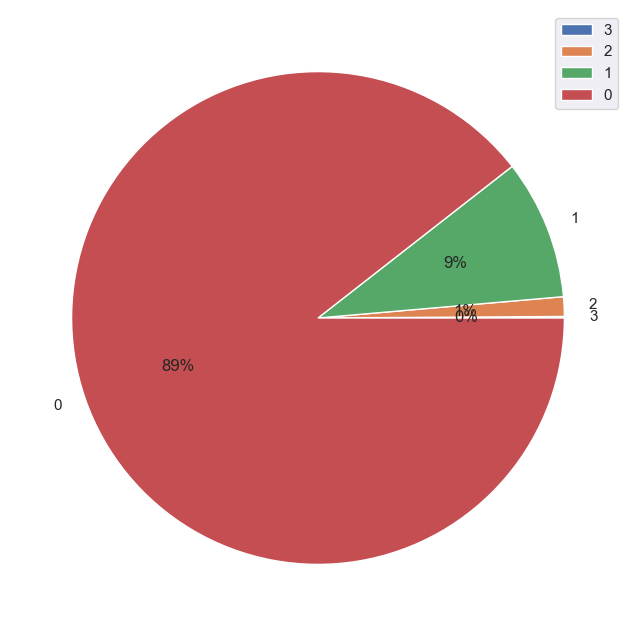

In [101]:
plt.pie(df_work1_count['clust_count'], labels=df_work1_count['cluster'], autopct='%.0f%%')
plt.legend();

In [102]:
df_positive = df_work1[df_work1['id'].isin(df_pos.astype(int))]
df_test = df_positive[(df_positive['dt']>=5) & (df_positive['dt']<=16)]

In [103]:
df_positive.shape[0]

63898

## вторая компани

In [104]:
y = df_work1[df_work1['city']==1134]
y.loc[:,'dt+'] = y['dt'].apply(lambda x: 0 if (x<15 or 30<x<45) else 1)
y.isna().sum()

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1401474328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:,'dt+'] = y['dt'].apply(lambda x: 0 if (x<15 or 30<x<45) else 1)


cluster          0
id               0
personal_coef    0
age              0
gender           0
city             0
country          0
education_cod    0
product          0
colour           0
cost             0
product_sex      0
base_sale        0
dt               0
anomaly          0
products         0
dt+              0
dtype: int64

In [105]:
xx =y.groupby(['id','dt+'], as_index=False).agg({'cost':'mean'})
day0 = xx[xx['dt+']==0]
day0.rename(columns={'dt+':'day0','cost':'cost0'},inplace=True)
day1 = xx[xx['dt+']==1]
day1.rename(columns={'dt+':'day1','cost':'cost1'},inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1749337209.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day0.rename(columns={'dt+':'day0','cost':'cost0'},inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1749337209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1.rename(columns={'dt+':'day1','cost':'cost1'},inplace=True)


In [106]:
avg_cost = pd.merge(left=day0, right=day1, on='id', how='outer')
avg_cost =avg_cost.fillna(0)

In [108]:
avg_cost.loc[:,'diff'] = avg_cost['cost1']-avg_cost['cost0']
avg_cost.loc[:,'reaction'] = avg_cost['diff'].apply(lambda x: 1 if x > 0 else 0)

In [109]:
avg_cost.reaction.value_counts()

0    15363
1    11446
Name: reaction, dtype: int64

## первая кампания

In [110]:
df_positive.loc[:,'dt+'] = df_positive['dt'].apply(lambda x: 0 if x<5 else 1)

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1086545398.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive.loc[:,'dt+'] = df_positive['dt'].apply(lambda x: 0 if x<5 else 1)


In [111]:
xx1 =df_positive.groupby(['id','dt+'], as_index=False).agg({'cost':'mean'})

In [112]:
day1_0 = xx1[xx1['dt+']==0]
day1_0.rename(columns={'dt+':'day0','cost':'cost0'},inplace=True)
day1_1 = xx1[xx1['dt+']==1]
day1_1.rename(columns={'dt+':'day1','cost':'cost1'},inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1924344929.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1_0.rename(columns={'dt+':'day0','cost':'cost0'},inplace=True)
C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\1924344929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day1_1.rename(columns={'dt+':'day1','cost':'cost1'},inplace=True)


In [113]:
avg_cost1 = pd.merge(left=day1_0, right=day1_1, on='id', how='outer')
avg_cost1 =avg_cost1.fillna(0)

In [114]:
avg_cost1.loc[:,'diff'] = avg_cost1['cost1']-avg_cost1['cost0']
avg_cost1.loc[:,'reaction'] = avg_cost1['diff'].apply(lambda x: 1 if x > 0 else 0)

In [115]:
avg_cost1.reaction.value_counts()

1    3227
0    1757
Name: reaction, dtype: int64

In [116]:
# прикрепить к основному и фильтр по городу
df_company = df_work1[(df_work1['id'].isin(df_pos.astype(int))) | ((df_work1['city']==1134))].reset_index().drop("index", axis=1)
df_finish = pd.merge(left=df_company, right=avg_cost1[['id','reaction']], on = 'id', how='outer').reset_index().drop("index", axis=1)
df_finish_full = df_finish.loc[~df_finish.reaction.isna()].reset_index().drop("index", axis=1)
df_finish_notfull = df_finish.loc[df_finish.reaction.isna()].reset_index().drop("index", axis=1)
df_finish_notfull.reset_index().drop("index", axis=1, inplace=True)

In [117]:
df_finish_notfull = df_finish_notfull.set_index('id')
avg_cost = avg_cost.set_index('id')
df_finish_notfull.update(avg_cost)
df_finish_notfull = df_finish_notfull.reset_index()

## Подготовка закончена

In [118]:
df_finish = pd.concat([df_finish_full, df_finish_notfull]).reset_index().drop("index", axis=1)

In [119]:
df_finish[df_finish.duplicated()]

,cluster,id,personal_coef,age,gender,city,country,education_cod,product,colour,cost,product_sex,base_sale,dt,anomaly,products,reaction


## предсказания склонности к покупке

In [120]:
df_preds = df_finish.copy().reset_index().drop(['index','colour','country'],axis=1)
df_preds.drop('product',axis=1,inplace=True)

In [121]:
x = df_preds.drop('reaction', axis=1)
y = df_preds['reaction']

In [122]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)
cat_features = [12]
data = Pool(data=x_train, label=y_train, cat_features=cat_features)


In [123]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=14)
model.fit(data, eval_set = (x_test,y_test), verbose=False)

In [124]:
prediction = model.predict_proba(x_train)
roc_auc_score(y_train, prediction[:,1])

0.9877546836701817

In [125]:
prediction = model.predict_proba(x_test)
roc_auc_score(y_test, prediction[:,1])

0.9003907950281003

In [126]:
eval_pool = Pool(x_test, y_test, cat_features=cat_features)

In [127]:
from catboost.utils import get_roc_curve
curve = get_roc_curve(model,eval_pool)
(frp, trp, treshold) = curve
roc_auc = auc(frp,trp)

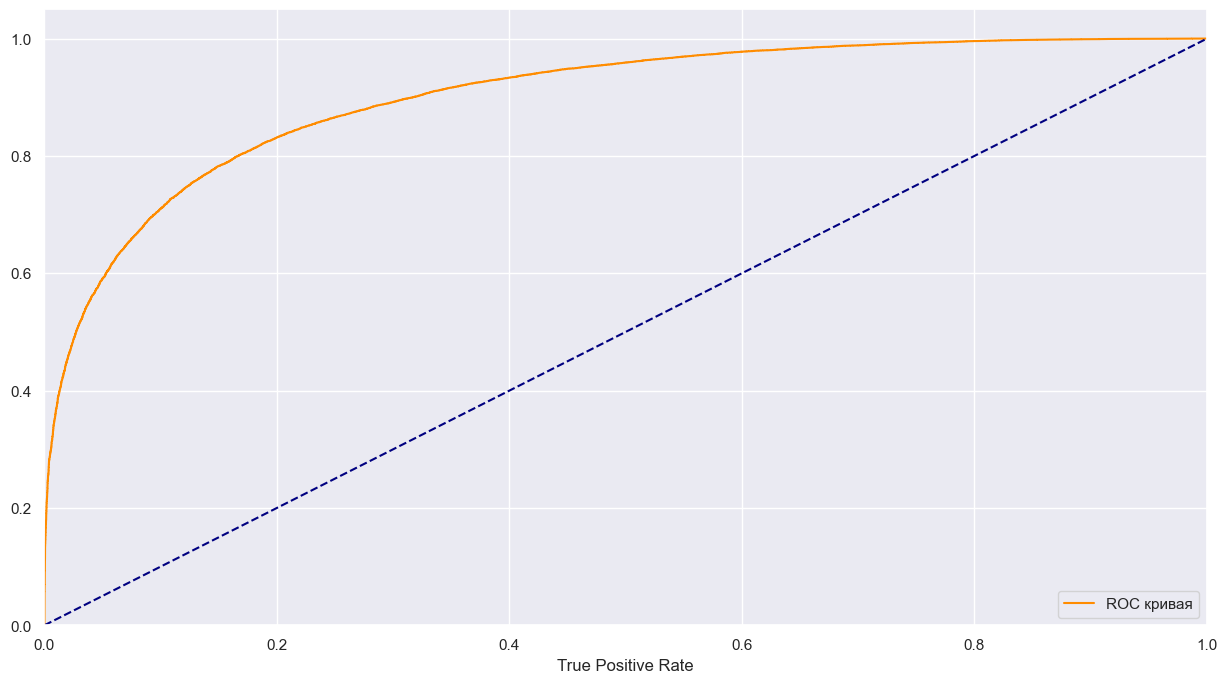

In [128]:
plt.plot(frp,trp, color='darkorange', label='ROC кривая' % roc_auc)
plt.plot([0,1],[0,1], color='navy', linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.grid(True)
plt.legend(loc='lower right')
plt.show();

In [129]:
prediction = model.predict(x_train)
prediction1 = model.predict(x_test)

In [130]:
accuracy_score(y_train, prediction)

0.9413350864668026

In [131]:
accuracy_score(y_test, prediction1)

0.8175860297894196

# обучение всей выборки

In [132]:
data = Pool(data=x, label=y, cat_features=cat_features)

In [133]:
model.fit(data, verbose=False)

In [134]:
next_campaign = df_work1[df_work1['city']==1188]
next_campaign.drop(['product','country','colour'], axis=1,inplace=True)

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\3812236358.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_campaign.drop(['product','country','colour'], axis=1,inplace=True)


In [135]:
next_campaign

,cluster,id,personal_coef,age,gender,city,education_cod,cost,product_sex,base_sale,dt,anomaly,products
10,0,6,0.4304,52.0,1.0,1188,0,4999,3.0,0,1,0,boots
11,0,6,0.4304,52.0,1.0,1188,0,4799,1.0,1,3,0,boots
12,0,6,0.4304,52.0,1.0,1188,0,999,1.0,0,8,0,dress
13,0,6,0.4304,52.0,1.0,1188,0,1119,2.0,1,11,0,dress
14,0,6,0.4304,52.0,1.0,1188,0,299,2.0,0,11,0,dress
...,...,...,...,...,...,...,...,...,...,...,...,...,...
786122,1,177641,0.5072,45.0,0.0,1188,0,11199,1.0,0,5,0,boots
786123,0,177641,0.5072,45.0,0.0,1188,0,2999,0.0,0,51,0,dress
786257,0,178002,0.4304,50.0,1.0,1188,0,5999,1.0,0,0,0,boots
786258,0,178002,0.4304,50.0,1.0,1188,0,3499,1.0,0,57,0,boots


In [136]:
# прогноз
next_campaign.loc[:,'reaction'] = model.predict(next_campaign)

C:\Users\Acer\AppData\Local\Temp\ipykernel_10576\115595672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  next_campaign.loc[:,'reaction'] = model.predict(next_campaign)


In [137]:
next_campaign.reaction.value_counts()

1.0    67276
0.0    21612
Name: reaction, dtype: int64

In [138]:
(next_campaign[next_campaign.reaction==1].shape[0])/(next_campaign[next_campaign.reaction==0].shape[0]+next_campaign[next_campaign.reaction==1].shape[0])

0.7568625686256862

In [139]:
# согласно предсказанию модели - 76% успех новой компании

# Поиски

## модель CatBoostClassifier с закодированными категориями продуктов

In [148]:
preds_product = df_preds.copy()

In [151]:
ohe = OneHotEncoder()
Y_ohe = ohe.fit_transform(preds_product[['products']]).toarray()

In [152]:
ecod_Y = pd.DataFrame(Y_ohe)
ecod_Y.columns = ohe.get_feature_names_out()

In [153]:
preds_product = preds_product.join(ecod_Y)

In [154]:
preds_product.drop('products', axis=1,inplace=True)

In [155]:
x = preds_product.drop('reaction', axis=1)
y = preds_product['reaction']

In [156]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)
data = Pool(data=x_train, label=y_train)

In [157]:
model = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=12)
model.fit(data, verbose=False)

In [158]:
prediction = model.predict_proba(x_train)
roc_auc_score(y_train, prediction[:,1])

0.9714161698305802

In [159]:
prediction = model.predict_proba(x_test)
roc_auc_score(y_test, prediction[:,1])

0.8915052656498325

## Градиентный бустинг

In [140]:
from sklearn.ensemble import HistGradientBoostingClassifier

In [160]:

clf = HistGradientBoostingClassifier(max_iter=1000, max_depth=12)

In [161]:
clf.get_params()

{'categorical_features': None,
 'class_weight': None,
 'early_stopping': 'auto',
 'interaction_cst': None,
 'l2_regularization': 0.0,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': 12,
 'max_iter': 1000,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': None,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [162]:
clf.fit(x_train, y_train)

HistGradientBoostingClassifier(max_depth=12, max_iter=1000)

In [163]:
prediction = clf.predict(x_train)
prediction1 = clf.predict(x_test)

In [164]:
accuracy_score(y_train, prediction)

0.8138130205856974

In [165]:
accuracy_score(y_test, prediction1)

0.7771903633599496

### логистическая регрессия

In [166]:
clf = LogisticRegression()
clf.fit(x_train, y_train)

LogisticRegression()

In [167]:
lr_probe = clf.predict_proba(x_test)[:,1]


In [168]:
lr_auc = roc_auc_score(y_test,lr_probe)
print(f'logisticRegression: {lr_auc}')

logisticRegression: 0.485256928057016


### дерево решений

In [169]:
clf1 = DecisionTreeClassifier(max_depth=5)
clf1.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5)

In [170]:
tree_probe = clf1.predict_proba(x_test)[:,1]

In [171]:
tree_auc = roc_auc_score(y_test,tree_probe)
print(f'DecisionTreeClassifier: {tree_auc}')

DecisionTreeClassifier: 0.6282328660138042


### случайный лес

In [172]:
clf = RandomForestClassifier(random_state=42)
clf.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [173]:
prediction = clf.predict(x_train)
prediction1 = clf.predict(x_test)

In [174]:
accuracy_score(y_train, prediction)

1.0

In [175]:
accuracy_score(y_test, prediction1)

0.7380192568446715

### подбор параметров для леса

In [176]:
param_grid = {
    'n_estimators': list(range(100,501,100)),
    'max_features':['sqrt','log2'],
    'min_samples_leaf': list(range(1,10))
}

In [177]:
forest = RandomForestClassifier(random_state=42)
randomized_search = RandomizedSearchCV(
    estimator=forest,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',
    verbose=1,
    n_jobs=1
)

In [178]:
randomized_search.fit(x_train,y_train)
best_params = randomized_search.best_params_
print(best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 'log2'}


In [179]:
clf = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, max_features='log2')
clf.fit(x_train, y_train)

RandomForestClassifier(max_features='log2', n_estimators=500)

In [180]:
prediction = clf.predict(x_train)
prediction1 = clf.predict(x_test)

In [181]:
accuracy_score(y_train, prediction)

1.0

In [182]:
accuracy_score(y_test, prediction1)

0.7460178324407982

## ансамбль

In [183]:
from sklearn.ensemble import BaggingClassifier


modelClf = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=500, random_state=12)


modelClf.fit(x_train, y_train)
print(modelClf.score(x_test, y_test))

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.5213181214304302


In [184]:
from sklearn.ensemble import AdaBoostClassifier


modelClf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=500, random_state=12)

modelClf.fit(x_train, y_train)
print(modelClf.score(x_test, y_test))

C:\Users\Acer\anaconda3\Lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


0.6763042197964746


In [185]:
from sklearn.ensemble import GradientBoostingClassifier

modelClf = GradientBoostingClassifier(max_depth=2, n_estimators=550,
                                      random_state=12, learning_rate=1)

modelClf.fit(x_train, y_train)
print(modelClf.score(x_test, y_test))

0.7013819456809062


## со стандартизацией

In [186]:
sc = StandardScaler()
X_sc = sc.fit(x_train)
X_train_sc = X_sc.transform(x_train)

In [187]:
clf = LogisticRegression()
clf.fit(X_train_sc, y_train)

LogisticRegression()

In [188]:
X_test_sc = X_sc.transform(x_test)

In [189]:
clf.score(X_test_sc, y_test)

0.5245367263364058

In [190]:
clf1 = DecisionTreeClassifier()
clf1.fit(X_train_sc, y_train)

DecisionTreeClassifier()

In [191]:
X_test_sc = X_sc.transform(x_test)
clf1.score(X_test_sc, y_test)

0.6935888129511183

In [192]:
clf2 = RandomForestClassifier()
clf2.fit(X_train_sc, y_train)
X_test_sc = X_sc.transform(x_test)
clf2.score(X_test_sc, y_test)

0.7416761398655034

In [193]:
y_pred_proba = clf.predict_proba(X_test_sc)
metrics = roc_auc_score(y_test, y_pred_proba[:,1])
metrics

0.527316011137483

In [194]:
y_pred_proba = clf1.predict_proba(X_test_sc)
metrics = roc_auc_score(y_test, y_pred_proba[:,1])
metrics

0.6931912075620702

In [195]:
y_pred_proba = clf2.predict_proba(X_test_sc)
metrics = roc_auc_score(y_test, y_pred_proba[:,1])
metrics

0.8238037721352887